In [1]:
import alpdesign as alp
from alpdesign.seq import *
from alpdesign.mlp import *
from alpdesign.utils import *
import jax 
from jax_unirep import get_reps
import haiku as hk

In [3]:
def hamming(seq1, seq2): # seq1 and seq2 are of same length
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    hamming_distance = 0.
    for i in range(len(seqlist1)):
        if seqlist1[i] == seqlist2[i]:
            continue
        hamming_distance += 1.
    return 1 - hamming_distance / len(seqlist1)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
key = jax.random.PRNGKey(0)
batch_size = 16
bag_num = 6
target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQ'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
print(target_rep.shape)
seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ']

val_seqs = ['PTWIIFLKAQWEQHSNLTNMRTFPEV',
'TISHFVCNHDICAWIKDMQAMQIKMC',
'CESWLWKRLFDGHADRWRSMPDYPIW',
'YLVENPLMFPLVAAFIHQWTRQISWH',
'QTEERLEAQISIYYIGAWSHYKVTDE']

#plt.rcParams["figure.figsize"] = (12,12)
#fig, axs = plt.subplots(3)

#@jax.jit
def single_loop(key, seqs, val_seqs, params):

    # get labels
    labels = []
    for seq in seqs:
        labels.append(hamming(target_seq, seq))
    labels = jnp.array(labels)
    
    val_labels = []
    for val_seq in val_seqs:
        val_labels.append(hamming(target_seq, val_seq))
    val_labels = jnp.array(val_labels)
    
    reps = get_reps(seqs)[0]
    val_reps = get_reps(val_seqs)[0]
    key, _ = jax.random.split(key, num=2)
    forward = hk.without_apply_rng(hk.transform(alp.model_forward))
    params, mlp_loss, mlp_val_loss= alp.ensemble_train(key, forward, reps, labels, val_reps, val_labels, params)
    #axs[i].plot(mlp_loss)
    final_vec = alp.bayes_opt(forward, params, labels)
    print(final_vec.shape)
    
    # need to adjust length in the future
    logits = jax.random.normal(key, shape=(jnp.shape(oh_vec)))
    b_logits = jax.random.normal(key, shape=(batch_size,*jnp.shape(oh_vec)))
    params = forward_seqprop.init(key, logits)
    #loss_traces, loss, _seqs = pso_train(key, final_vec, b_logits, params, alp.seq.train_seqprop, batch_size, bag_num)
    loss_traces, loss, _seqs = pso_train(key, final_vec, b_logits, params)
    gen_seqs = []
    for seq in _seqs:
        seq = alp.utils.decode_seq(seq)
        str = ""
        gen_seqs.append(str.join(seq))
    # add data points
    seqs = [*seqs, *gen_seqs]
    return seqs, mlp_loss, mlp_val_loss, loss_traces, params

    
# for i in range(3):
#     losses = []
#     key, _ = jax.random.split(key, num=2)
#     seqs, mlp_loss = single_loop(key, seqs)
#     print(seqs)
#     losses.append(mlp_loss)
#     #axs[i].plot(mlp_loss)

(1, 1900)


In [ ]:
loop_mlp_loss = []
loop_mlp_val_loss = []
loop_seq_loss = []
loop_seq = []
params = None
for i in range(3):
    key, _ = jax.random.split(key, num=2)
    seqs, mlp_loss, mlp_val_loss, loss_traces, params= single_loop(key, seqs, val_seqs, params)
    loop_mlp_loss.append(mlp_loss)
    loop_mlp_val_loss.append(mlp_val_loss)
    loop_seq_loss.append(loss_traces)
    loop_seq.append(seqs)

(1, 1900)


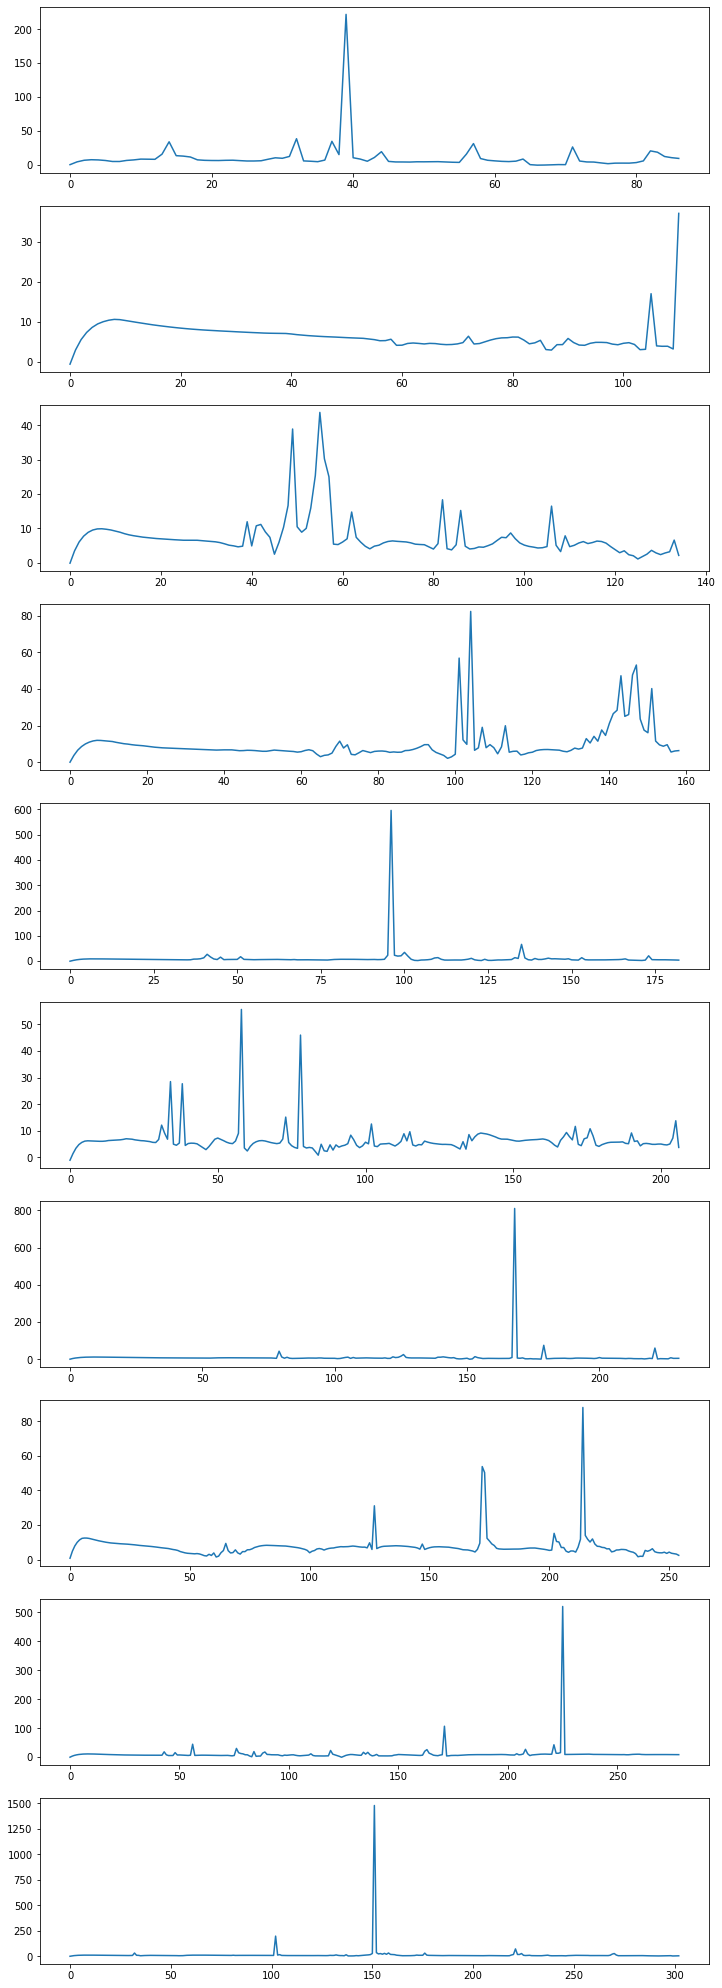

In [10]:
plt.rcParams["figure.figsize"] = (12, 36)
fig, axs = plt.subplots(10)
for i in range(10):
    axs[i].plot(loop_mlp_val_loss[i])

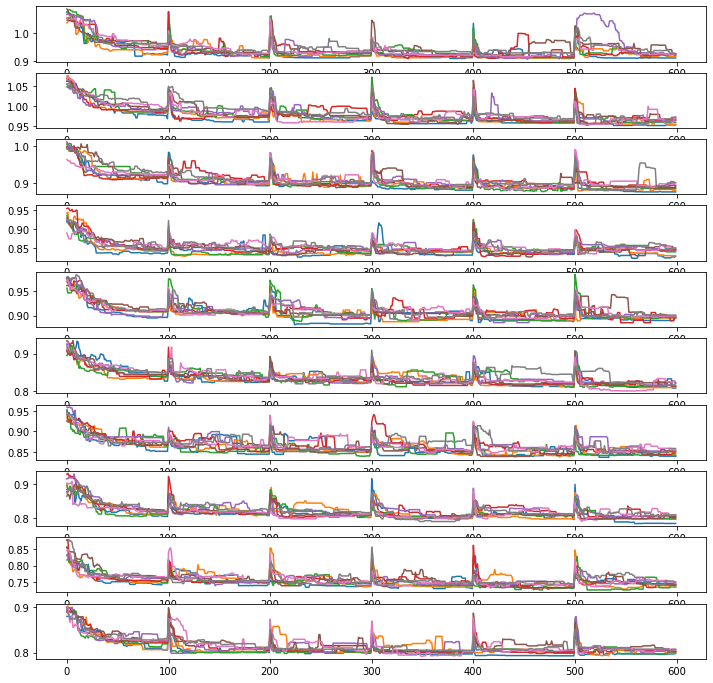

In [11]:
plt.rcParams["figure.figsize"] = (12, 12)
fig, axs = plt.subplots(10)
for i in range(10):
    for j in range(8):
        axs[i].plot(loop_seq_loss[i][j])

In [12]:
print(loop_seq)

[['GIGAVLKVLKAGLPALIVTLKRKIVQ', 'PPGATLKKHTTGSVALISWIWARIQQ', 'GIGAVLKVLTTGLKTLISAAKRKRAA', 'HAPPVLKVLTTGLAPPLVWIKRKRTH', 'GIGAVLUIHKLSSVAAWRPPKRKRQQ', 'GISGKVCVIIDMEPIGIILLLIMEPL', 'GIPGKVAVIIDMEPICIILPLIMEPL', 'GELGKPCVFLDIEYPCIINMLIMSIQ', 'WLLAAIPKDCPPVIIIDIDPFICIFF', 'GILGAIGKDCPVGIIIDIVPFICIFF', 'GISGKYCVLILLSPPGYILNLPDPIP', 'GLLGAIGKIHPGVIIIDIDPIIIIFF', 'GISPKPAVIIDIEWICIILLFIMAPE', 'WDCPDHCICHDSSMIMHKDSNPPDFP', 'PDVPIKCECHDKFMEMRQKKDPPDPE', 'FGDICEDKCICYCKYSSMMERIPPGI', 'PDDTCEDRCTCKCKFGSMKIPPGPER', 'WDCVHDECMCHYYDHVKGAEIYIEPP', 'DDVNIKCQCNWYFMPMRRKKDPPDGP', 'DPIMGDDITCSCHEGFGKKKEPPDPP', 'EDAVHGECMCNYFYHCKGDEPMIFPP', 'EDGKYICILFLCDMFIITYNCDGIDP', 'WIDGEKTICCCDGDIIYFDIDVPDFI', 'FIDGEKYICCCDDDIIITDVDPLDPI', 'VHDGEEYICVDDCNIIMFWYDDPPFV', 'EDGKYICIMDMGDMFIIIFDPNGPNP', 'VIDGEYIFCADDCFIITYTCDDPNDV', 'EDGKYICIVDFGDYFIIKFDVNGPNP', 'FIDGDKYICCCDHDFIIFDIDAPNFI', 'CDCKCACEMCRCPGSKSSNSSSMMYP', 'CDCHEGYENCQCHASHMIENSSQWMH', 'CDGHACYENCKCYCGQSSSHSSMMMH', 'CGDCPKCEMCTCHGSNNSSSSFMMLP', 'CDCPEEC

In [16]:
hamming(target_seq, 'DVVISCDGTIIIFFLFPCGIIDPNFP')

0.9615384615384616